In [1]:
import torch
from torch import nn
from transformers import PreTrainedTokenizerFast, AutoTokenizer
from datasets import load_dataset
from evaluate import load, combine
from tqdm import tqdm
    
from transformer import *
from dataset import *

from numba import cuda
device = cuda.get_current_device()
device.reset() 

In [2]:
# get data 
train = load_dataset('csv', data_files='../data/train.csv')['train']
test = load_dataset('csv', data_files='../data/test.csv')['train']
VAL_CUTOFF = 500 # random choice for val loss, full test set is 3110, take 500 away for validation only. 
val = test[:VAL_CUTOFF]
test = test[VAL_CUTOFF:]


# obolo_tokenizer = PreTrainedTokenizerFast(tokenizer_file='../custom_tokenizers/obolo-bpe-tokenizer.json', padding='left')
obolo_tokenizer = PreTrainedTokenizerFast(tokenizer_file='../custom_tokenizers/obolo-bpe-tokenizer-small.json', padding='left')
# obolo_tokenizer = PreTrainedTokenizerFast(tokenizer_file='../custom_tokenizers/obolo-wordpiece-tokenizer-small.json', padding='left')
# obolo_tokenizer = PreTrainedTokenizerFast(tokenizer_file='../custom_tokenizers/custom_plus_bpe_obolo_tokenizer/tokenizer.json', padding='left')
english_tokenizer = AutoTokenizer.from_pretrained('gpt2', padding='left')

# print(obolo_tokenizer.vocab_size)
print(len(obolo_tokenizer))
# print(english_tokenizer.vocab_size)
print(len(english_tokenizer))
print(DEVICE)

token_transform = {}
vocab_transform = {}

# token_transform[SRC_LANGUAGE] = obolo_tokenizer
# token_transform[TGT_LANGUAGE] = english_tokenizer

# vocab_transform[SRC_LANGUAGE] = obolo_tokenizer.vocab 
# vocab_transform[TGT_LANGUAGE] = english_tokenizer.vocab

SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'ob'
token_transform[SRC_LANGUAGE] = english_tokenizer
token_transform[TGT_LANGUAGE] = obolo_tokenizer

vocab_transform[SRC_LANGUAGE] = english_tokenizer.vocab 
vocab_transform[TGT_LANGUAGE] = english_tokenizer.vocab

# for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
#   vocab_transform[ln].set_default_index(UNK_IDX)
init_text_transform(token_transform, SRC_LANGUAGE, TGT_LANGUAGE)
# now this BPE tokenizer is also equipped with a decoder, so we should be able to do Obolo -> English and English -> Obolo

7150
50257
cuda
en ob


In [3]:
# ob_sent, en_sent = train['Obolo'][0], train['English'][0]
# print(ob_sent)
# print(obolo_tokenizer(ob_sent))
# print(text_transform[SRC_LANGUAGE](ob_sent))
# print(obolo_tokenizer(ob_sent)['input_ids'] == list(text_transform[SRC_LANGUAGE](ob_sent))[1:-1])
# print(en_sent)
# print(text_transform[TGT_LANGUAGE](en_sent))

In [3]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(token_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(token_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

# train_dataloader = generate_dataloader(train['Obolo'], train['English'], BATCH_SIZE)
# val_dataloader = generate_dataloader(val['Obolo'], val['English'], BATCH_SIZE)
# test_dataloader = generate_dataloader(test['Obolo'], test['English'], BATCH_SIZE)
train_dataloader = generate_dataloader(train['English'], train['Obolo'], BATCH_SIZE)
val_dataloader = generate_dataloader(val['English'], val['Obolo'], BATCH_SIZE)
test_dataloader = generate_dataloader(test['English'], test['Obolo'], BATCH_SIZE)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
display(transformer)
display(optimizer)

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [5]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        # save vram 
        del src, tgt
        torch.cuda.empty_cache()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

        # save vram 
        del src, tgt
        torch.cuda.empty_cache()

    return losses / len(list(val_dataloader))

In [6]:
from timeit import default_timer as timer

# NUM_EPOCHS = 10
NUM_EPOCHS = 50 

train_losses = []
val_losses = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    if epoch % 5 == 0:
        # torch.save(transformer, f'checkpoints/transformer_obolo_to_english_bpe_{epoch}_epochs.pt')
        torch.save(transformer, f'checkpoints/transformer_english_to_obolo_bpe_small_{epoch}_epochs.pt')

  0%|          | 0/438 [00:00<?, ?it/s]c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 438/438 [01:28<00:00,  4.96it/s]


Epoch: 1, Train loss: 4.783, Val loss: 3.865, Epoch time = 97.225s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 2, Train loss: 3.651, Val loss: 3.388, Epoch time = 95.152s


100%|██████████| 438/438 [01:26<00:00,  5.05it/s]


Epoch: 3, Train loss: 3.276, Val loss: 3.111, Epoch time = 95.390s


100%|██████████| 438/438 [01:27<00:00,  5.02it/s]


Epoch: 4, Train loss: 3.021, Val loss: 2.914, Epoch time = 97.120s


100%|██████████| 438/438 [01:27<00:00,  5.01it/s]


Epoch: 5, Train loss: 2.822, Val loss: 2.778, Epoch time = 96.121s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 6, Train loss: 2.659, Val loss: 2.669, Epoch time = 95.430s


100%|██████████| 438/438 [01:28<00:00,  4.96it/s]


Epoch: 7, Train loss: 2.522, Val loss: 2.576, Epoch time = 97.233s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 8, Train loss: 2.403, Val loss: 2.514, Epoch time = 95.285s


100%|██████████| 438/438 [01:27<00:00,  5.03it/s]


Epoch: 9, Train loss: 2.298, Val loss: 2.468, Epoch time = 95.975s


100%|██████████| 438/438 [01:28<00:00,  4.95it/s]


Epoch: 10, Train loss: 2.203, Val loss: 2.415, Epoch time = 98.047s


100%|██████████| 438/438 [01:27<00:00,  5.01it/s]


Epoch: 11, Train loss: 2.116, Val loss: 2.395, Epoch time = 96.367s


100%|██████████| 438/438 [01:28<00:00,  4.96it/s]


Epoch: 12, Train loss: 2.035, Val loss: 2.355, Epoch time = 97.248s


100%|██████████| 438/438 [01:27<00:00,  4.98it/s]


Epoch: 13, Train loss: 1.958, Val loss: 2.342, Epoch time = 97.195s


100%|██████████| 438/438 [01:28<00:00,  4.96it/s]


Epoch: 14, Train loss: 1.891, Val loss: 2.304, Epoch time = 97.514s


100%|██████████| 438/438 [01:28<00:00,  4.97it/s]


Epoch: 15, Train loss: 1.826, Val loss: 2.294, Epoch time = 97.311s


100%|██████████| 438/438 [01:27<00:00,  4.98it/s]


Epoch: 16, Train loss: 1.762, Val loss: 2.287, Epoch time = 96.595s


100%|██████████| 438/438 [01:26<00:00,  5.04it/s]


Epoch: 17, Train loss: 1.706, Val loss: 2.280, Epoch time = 95.481s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 18, Train loss: 1.651, Val loss: 2.266, Epoch time = 95.282s


100%|██████████| 438/438 [01:28<00:00,  4.96it/s]


Epoch: 19, Train loss: 1.598, Val loss: 2.263, Epoch time = 97.553s


100%|██████████| 438/438 [01:26<00:00,  5.05it/s]


Epoch: 20, Train loss: 1.548, Val loss: 2.270, Epoch time = 95.397s


100%|██████████| 438/438 [01:26<00:00,  5.05it/s]


Epoch: 21, Train loss: 1.502, Val loss: 2.287, Epoch time = 95.431s


100%|██████████| 438/438 [01:26<00:00,  5.04it/s]


Epoch: 22, Train loss: 1.456, Val loss: 2.293, Epoch time = 95.565s


100%|██████████| 438/438 [01:26<00:00,  5.07it/s]


Epoch: 23, Train loss: 1.410, Val loss: 2.297, Epoch time = 95.274s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 24, Train loss: 1.367, Val loss: 2.310, Epoch time = 95.193s


100%|██████████| 438/438 [01:26<00:00,  5.08it/s]


Epoch: 25, Train loss: 1.328, Val loss: 2.297, Epoch time = 94.998s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 26, Train loss: 1.285, Val loss: 2.312, Epoch time = 95.343s


100%|██████████| 438/438 [01:26<00:00,  5.05it/s]


Epoch: 27, Train loss: 1.247, Val loss: 2.323, Epoch time = 95.472s


100%|██████████| 438/438 [01:26<00:00,  5.07it/s]


Epoch: 28, Train loss: 1.211, Val loss: 2.344, Epoch time = 95.284s


100%|██████████| 438/438 [01:26<00:00,  5.04it/s]


Epoch: 29, Train loss: 1.175, Val loss: 2.352, Epoch time = 95.608s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 30, Train loss: 1.141, Val loss: 2.357, Epoch time = 95.249s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 31, Train loss: 1.109, Val loss: 2.381, Epoch time = 95.147s


100%|██████████| 438/438 [01:26<00:00,  5.09it/s]


Epoch: 32, Train loss: 1.077, Val loss: 2.393, Epoch time = 94.778s


100%|██████████| 438/438 [01:26<00:00,  5.08it/s]


Epoch: 33, Train loss: 1.045, Val loss: 2.400, Epoch time = 94.925s


100%|██████████| 438/438 [01:26<00:00,  5.07it/s]


Epoch: 34, Train loss: 1.013, Val loss: 2.430, Epoch time = 95.158s


100%|██████████| 438/438 [01:26<00:00,  5.07it/s]


Epoch: 35, Train loss: 0.984, Val loss: 2.441, Epoch time = 95.094s


100%|██████████| 438/438 [01:26<00:00,  5.08it/s]


Epoch: 36, Train loss: 0.957, Val loss: 2.458, Epoch time = 94.944s


100%|██████████| 438/438 [01:27<00:00,  5.00it/s]


Epoch: 37, Train loss: 0.930, Val loss: 2.481, Epoch time = 97.127s


100%|██████████| 438/438 [01:27<00:00,  4.98it/s]


Epoch: 38, Train loss: 0.900, Val loss: 2.509, Epoch time = 96.888s


100%|██████████| 438/438 [01:27<00:00,  5.03it/s]


Epoch: 39, Train loss: 0.875, Val loss: 2.520, Epoch time = 96.005s


100%|██████████| 438/438 [01:27<00:00,  5.00it/s]


Epoch: 40, Train loss: 0.849, Val loss: 2.549, Epoch time = 96.287s


100%|██████████| 438/438 [01:26<00:00,  5.05it/s]


Epoch: 41, Train loss: 0.823, Val loss: 2.570, Epoch time = 95.383s


100%|██████████| 438/438 [01:28<00:00,  4.96it/s]


Epoch: 42, Train loss: 0.800, Val loss: 2.587, Epoch time = 97.360s


100%|██████████| 438/438 [01:28<00:00,  4.94it/s]


Epoch: 43, Train loss: 0.777, Val loss: 2.608, Epoch time = 97.962s


100%|██████████| 438/438 [01:28<00:00,  4.97it/s]


Epoch: 44, Train loss: 0.754, Val loss: 2.618, Epoch time = 97.172s


100%|██████████| 438/438 [01:27<00:00,  5.03it/s]


Epoch: 45, Train loss: 0.732, Val loss: 2.644, Epoch time = 95.936s


100%|██████████| 438/438 [01:27<00:00,  5.01it/s]


Epoch: 46, Train loss: 0.708, Val loss: 2.658, Epoch time = 96.518s


100%|██████████| 438/438 [01:26<00:00,  5.05it/s]


Epoch: 47, Train loss: 0.690, Val loss: 2.682, Epoch time = 95.571s


100%|██████████| 438/438 [01:26<00:00,  5.04it/s]


Epoch: 48, Train loss: 0.672, Val loss: 2.694, Epoch time = 95.476s


100%|██████████| 438/438 [01:26<00:00,  5.06it/s]


Epoch: 49, Train loss: 0.652, Val loss: 2.716, Epoch time = 95.358s


100%|██████████| 438/438 [01:27<00:00,  5.00it/s]


Epoch: 50, Train loss: 0.636, Val loss: 2.733, Epoch time = 96.494s


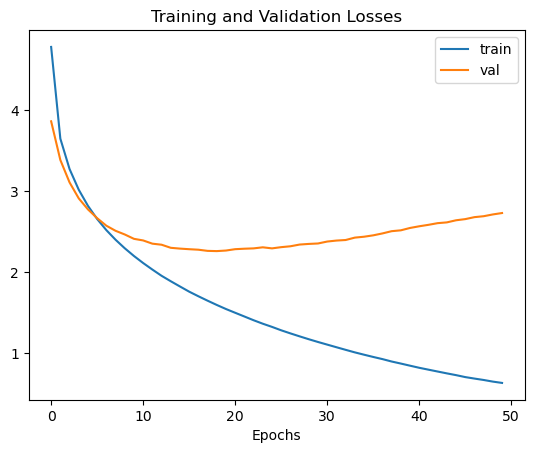

In [7]:
import matplotlib.pyplot as plt 
import numpy as np

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.show()

In [9]:
torch.save(transformer.state_dict(), 'transformer_obolo_to_english_bpe_dict.pt')

In [10]:
torch.save(transformer, 'transformer_obolo_to_english_bpe.pt')

In [48]:
m=torch.load('transformer_obolo_to_english_bpe.pt')
m

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [16]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        # print(out)
        # print(english_tokenizer.decode(out))
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        # print(next_word)
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # save vram
        del tgt_mask 
        torch.cuda.empty_cache()
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    
    return token_transform[TGT_LANGUAGE].decode(tgt_tokens[1:-1])
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("[CLS]", "").replace("[SEP]", "")


In [9]:
src_sentence = "ire, emi okumugwem mâtap oke me etete anam ebi ijeren mè echi ebi ijipiti. anam geege me etete echi ebi ijeren ìkpokwu"
src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
print(list(src.numpy().flatten()), src.shape)
print(token_transform[SRC_LANGUAGE].decode(src.numpy().flatten()))

[1, 24, 73, 8, 42, 108, 24, 42, 660, 1518, 124, 42, 163, 42, 85, 319, 42, 660, 20, 42, 405, 42, 694, 694, 20, 42, 168, 28, 42, 20, 69, 42, 24, 89, 239, 42, 405, 42, 58, 42, 20, 110, 42, 20, 69, 42, 24, 8207, 5228, 24, 10, 42, 168, 28, 42, 88, 5997, 42, 405, 42, 694, 694, 20, 42, 20, 110, 42, 20, 69, 42, 24, 89, 239, 42, 24, 42, 58, 415, 214, 2] torch.Size([80, 1])
[CLS]ire, emi okumugwem ma ̂tap oke me etete anam ebi ijeren me ̀ echi ebi ijipiti. anam geege me etete echi ebi ijeren i ̀kpokwu[SEP]


MAKE TRANSLATE ACTUALLY WORK !!!

In [ ]:
test = load_dataset('csv', data_files='../data/test.csv')['train']
print(len(test))

In [17]:
chrf = load('chrf')
gleu = load('google_bleu')
rouge = load('rouge') 
bleu = load('bleu')
meteor = load('meteor')
metrics = combine([chrf, bleu, rouge, meteor, gleu])

def test_model(m):
    preds = []
    refs = []
    for idx in tqdm(range(len(test['Obolo']))):
        ob, en = test['Obolo'][idx], test['English'][idx]
        refs.append(en)
        pred = translate(m, ob)
        preds.append(pred)
    print(len(preds), len(refs))
    chrf_plusplus = chrf.compute(predictions=preds, references=refs, word_order=2)
    other_metrics = metrics.compute(predictions=preds, references=refs)
    return (chrf_plusplus, other_metrics)
# def test_model(m):
#     preds = []
#     refs = []
#     for idx in tqdm(range(len(test['Obolo']))):
#         ob, en = test['Obolo'][idx], test['English'][idx]
#         refs.append(ob)
#         pred = translate(m, en)
#         preds.append(pred)
#     print(len(preds), len(refs))
#     chrf_plusplus = chrf.compute(predictions=preds, references=refs, word_order=2)
#     other_metrics = metrics.compute(predictions=preds, references=refs)
#     return (chrf_plusplus, other_metrics)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
models = []
for epoch in [10,20,30,40,50]:
    model = torch.load(f'checkpoints/transformer_english_to_obolo_bpe_small_{epoch}_epochs.pt').to(DEVICE)
    models.append(model)
display(models[0])
scores = []
for mod in models:
    score = test_model(mod)
    display(score)
    scores.append(score) 

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

100%|██████████| 2610/2610 [08:29<00:00,  5.12it/s] 


2610 2610


({'score': 31.4594364184561, 'char_order': 6, 'word_order': 2, 'beta': 2},
 {'score': 33.1183382693422,
  'char_order': 6,
  'word_order': 0,
  'beta': 2,
  'bleu': 0.0965839369096732,
  'precisions': [0.4439593452564786,
   0.17493879692235953,
   0.07409034447238465,
   0.03506087943978298],
  'brevity_penalty': 0.8104037923231848,
  'length_ratio': 0.8262942384205826,
  'translation_length': 71234,
  'reference_length': 86209,
  'rouge1': 0.40209917560946296,
  'rouge2': 0.1688320075056018,
  'rougeL': 0.330439312992152,
  'rougeLsum': 0.3302889543180393,
  'meteor': 0.27499811487427545,
  'google_bleu': 0.14902439883938115})

100%|██████████| 2610/2610 [08:12<00:00,  5.29it/s]


2610 2610


({'score': 34.60890032170223, 'char_order': 6, 'word_order': 2, 'beta': 2},
 {'score': 36.45257913325245,
  'char_order': 6,
  'word_order': 0,
  'beta': 2,
  'bleu': 0.12375037959937117,
  'precisions': [0.46202111368595083,
   0.19926665823745102,
   0.09609018389698269,
   0.05197010354603478],
  'brevity_penalty': 0.8451120090240163,
  'length_ratio': 0.8559547147049612,
  'translation_length': 73791,
  'reference_length': 86209,
  'rouge1': 0.42594365363152303,
  'rouge2': 0.19672495711620275,
  'rougeL': 0.35142566208222015,
  'rougeLsum': 0.3515269770697331,
  'meteor': 0.2990011024367041,
  'google_bleu': 0.16980087851142414})

100%|██████████| 2610/2610 [08:15<00:00,  5.27it/s]


2610 2610


({'score': 35.8645034031162, 'char_order': 6, 'word_order': 2, 'beta': 2},
 {'score': 37.871225550705056,
  'char_order': 6,
  'word_order': 0,
  'beta': 2,
  'bleu': 0.1314852977175387,
  'precisions': [0.46451269069349144,
   0.2040996618124094,
   0.10156798167108183,
   0.05624395686128672],
  'brevity_penalty': 0.8619043144601847,
  'length_ratio': 0.8706167569511304,
  'translation_length': 75055,
  'reference_length': 86209,
  'rouge1': 0.43278884146234514,
  'rouge2': 0.20327690740077292,
  'rougeL': 0.35567630273607376,
  'rougeLsum': 0.35554910123929573,
  'meteor': 0.3055120263009529,
  'google_bleu': 0.17569874243778957})

100%|██████████| 2610/2610 [08:08<00:00,  5.34it/s]


2610 2610


({'score': 36.190355946973, 'char_order': 6, 'word_order': 2, 'beta': 2},
 {'score': 38.37663027147303,
  'char_order': 6,
  'word_order': 0,
  'beta': 2,
  'bleu': 0.12951030123890808,
  'precisions': [0.47209337124046086,
   0.20605616123436243,
   0.10222131111534125,
   0.05645210401315389],
  'brevity_penalty': 0.8413865042709813,
  'length_ratio': 0.8527299933881614,
  'translation_length': 73513,
  'reference_length': 86209,
  'rouge1': 0.43998740386245805,
  'rouge2': 0.2079964625119528,
  'rougeL': 0.3639936206259728,
  'rougeLsum': 0.36428226798504276,
  'meteor': 0.3073477292188966,
  'google_bleu': 0.17534979953009386})

100%|██████████| 2610/2610 [08:14<00:00,  5.27it/s]


2610 2610


({'score': 35.64635608493907, 'char_order': 6, 'word_order': 2, 'beta': 2},
 {'score': 37.75723550215659,
  'char_order': 6,
  'word_order': 0,
  'beta': 2,
  'bleu': 0.12596321547781203,
  'precisions': [0.4652110195356091,
   0.19899117979015424,
   0.09670749164943535,
   0.05313537800351631],
  'brevity_penalty': 0.8529268967889252,
  'length_ratio': 0.8627521488475681,
  'translation_length': 74377,
  'reference_length': 86209,
  'rouge1': 0.43130980811161257,
  'rouge2': 0.20000287266562097,
  'rougeL': 0.3543503409004035,
  'rougeLsum': 0.3545369197114089,
  'meteor': 0.3012917120566398,
  'google_bleu': 0.17186173367915422})

In [19]:
scores

[({'score': 31.4594364184561, 'char_order': 6, 'word_order': 2, 'beta': 2},
  {'score': 33.1183382693422,
   'char_order': 6,
   'word_order': 0,
   'beta': 2,
   'bleu': 0.0965839369096732,
   'precisions': [0.4439593452564786,
    0.17493879692235953,
    0.07409034447238465,
    0.03506087943978298],
   'brevity_penalty': 0.8104037923231848,
   'length_ratio': 0.8262942384205826,
   'translation_length': 71234,
   'reference_length': 86209,
   'rouge1': 0.40209917560946296,
   'rouge2': 0.1688320075056018,
   'rougeL': 0.330439312992152,
   'rougeLsum': 0.3302889543180393,
   'meteor': 0.27499811487427545,
   'google_bleu': 0.14902439883938115}),
 ({'score': 34.60890032170223, 'char_order': 6, 'word_order': 2, 'beta': 2},
  {'score': 36.45257913325245,
   'char_order': 6,
   'word_order': 0,
   'beta': 2,
   'bleu': 0.12375037959937117,
   'precisions': [0.46202111368595083,
    0.19926665823745102,
    0.09609018389698269,
    0.05197010354603478],
   'brevity_penalty': 0.845112009

In [ ]:
# models = []
# for epoch in [10,20,30,40,50]:
#     model = torch.load(f'checkpoints/transformer_obolo_to_english_combination_{epoch}_epochs.pt').to(DEVICE)
#     models.append(model)

# scores = []
# for mod in models:
#     score = test_model(mod)
#     display(score)
#     scores.append(score) 

100%|██████████| 2610/2610 [08:42<00:00,  4.99it/s]


2610 2610


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'score': 34.774253886934794,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.11017722886419022,
 'precisions': [0.386394229803307,
  0.15402946273830156,
  0.07010792358416555,
  0.03531553927340922],
 'brevity_penalty': 1.0,
 'length_ratio': 1.2377186765638406,
 'translation_length': 99546,
 'reference_length': 80427,
 'rouge1': 0.38876618138191454,
 'rouge2': 0.15167336303164228,
 'rougeL': 0.32818470447982817,
 'rougeLsum': 0.3281664178921254,
 'meteor': 0.33593630617140496,
 'google_bleu': 0.1614613648663828}

100%|██████████| 2610/2610 [08:06<00:00,  5.37it/s]


2610 2610


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'score': 38.37993393545994,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.14979800723917194,
 'precisions': [0.4484263392857143,
  0.1950339119439016,
  0.10005925574780754,
  0.05753943989238107],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1140537381725042,
 'translation_length': 89600,
 'reference_length': 80427,
 'rouge1': 0.43388821312249637,
 'rouge2': 0.1880674209030742,
 'rougeL': 0.36556917629854546,
 'rougeLsum': 0.3654439543934844,
 'meteor': 0.37230503517222907,
 'google_bleu': 0.19485563169449804}

100%|██████████| 2610/2610 [07:21<00:00,  5.91it/s]


2610 2610


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'score': 38.92617419691285,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.17018996617377927,
 'precisions': [0.483790461763866,
  0.21497773614443916,
  0.11491124417477662,
  0.07019763715633554],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0013925671727155,
 'translation_length': 80539,
 'reference_length': 80427,
 'rouge1': 0.4500795318755542,
 'rouge2': 0.20127863292405612,
 'rougeL': 0.37816123135216684,
 'rougeLsum': 0.37799380918349657,
 'meteor': 0.37445390228135883,
 'google_bleu': 0.20451922850481596}

100%|██████████| 2610/2610 [08:07<00:00,  5.35it/s]


2610 2610


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'score': 40.41674493084158,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.16555905508506247,
 'precisions': [0.4631978124613186,
  0.20965254993797605,
  0.11296280799072292,
  0.06848723422634105],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1049398833724993,
 'translation_length': 88867,
 'reference_length': 80427,
 'rouge1': 0.4492976833221257,
 'rouge2': 0.20482741611037522,
 'rougeL': 0.3783352021612897,
 'rougeLsum': 0.3782361068174826,
 'meteor': 0.38591053665286484,
 'google_bleu': 0.20687099470604625}

100%|██████████| 2610/2610 [08:28<00:00,  5.13it/s]


2610 2610


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'score': 40.721980527557136,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.15932930884219138,
 'precisions': [0.44594331878861193,
  0.19924870523905844,
  0.10826618441534658,
  0.06699072653908776],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1512054409588819,
 'translation_length': 92588,
 'reference_length': 80427,
 'rouge1': 0.4438558502216844,
 'rouge2': 0.20023932342100625,
 'rougeL': 0.37049227050340316,
 'rougeLsum': 0.37035164579594804,
 'meteor': 0.3807886400626061,
 'google_bleu': 0.20173534614675015}

In [54]:
print(len(preds), len(refs))

3110 3110


In [4]:
# metrics
chrf = load('chrf')
gleu = load('google_bleu')
rouge = load('rouge') 
bleu = load('bleu')
meteor = load('meteor')
metrics = combine([chrf, bleu, rouge, meteor, gleu])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [56]:
scores = metrics.compute(predictions=preds, references=refs)
scores

{'score': 33.04091540787891,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.10531583607718822,
 'precisions': [0.39940596433941206,
  0.15199285856734504,
  0.06464365746494309,
  0.0313480889373341],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1160628802618981,
 'translation_length': 108411,
 'reference_length': 97137,
 'rouge1': 0.3765356456692016,
 'rouge2': 0.13864376297768582,
 'rougeL': 0.31799077304173684,
 'rougeLsum': 0.3181688900030759,
 'meteor': 0.3184619515531625,
 'google_bleu': 0.1572599755737436}

In [5]:
# sample sentence translation
import torch
from datasets import load_dataset
m = torch.load('transformer_obolo_to_english_bpe.pt').to('cuda')

In [8]:
print(test['English'][100])
print(translate(m, test['Obolo'][100]))

hear ye now what the lord saith; arise, contend thou before the mountains, and let the hills hear thy voice.
hearken ye unto the lord, saith the lord; hear ye from the mountain, and hear your words, which hear your words which hear your words.


In [14]:
sentence = "ogwu ubọọn̄ oneniyaka ido siba ibe, “sà gwun̄ nte uwu kwun̄ ìkup me owa?” siba ofọfọọk ibe ke ọmọ òwa me jeruselem okupbe, mije, ìkikeek ibe, usini mgbọ, cherekeyi, ke ebi uwu kè ijeren mêniyaka irek mkpulu nte nte kan̄ inyi ọmọ."
print(translate(m, sentence))

and the king said unto zerah, what [is] thy father? and he said unto him, behold, i [am] this day: for this day is come to jerusalem, because he hath sent me to day, and said, this is come unto me, and i will give him to my father.


In [9]:
# preds = []
# refs = []
# for idx in tqdm(range(300)):
#     ob, en = test['Obolo'][idx], test['English'][idx]
#     refs.append(en)
#     pred = translate(m, ob)
#     preds.append(pred)
    
# scores = metrics.compute(predictions=preds, references=refs)
# scores